## Importación de librerías

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd())) # Change working directory to parent directory

In [2]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from test_harness.datasets.dataset import Dataset
from test_harness.experiments._1_baseline_experiment import BaselineExperiment
from test_harness.experiments._2_response_uncertainty_experiment import UncertaintyKSExperiment
from test_harness.experiments._3_margin_uncertainty_experiment import UncertaintyX2Experiment
from test_harness.experiments._4_margin_threshold_experiment import MarginThresholdExperiment
from test_harness.experiments._5_topline_experiment import ToplineExperiment

from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_KS_drift_distributions,
    plot_XS_drift_margin_distributions
)

import matplotlib.pyplot as plt

%matplotlib inline

## Preparación de los experimentos

In [3]:
def define_run_exps(model, param_grid, dataset, delete_csv=False):

    exps = []

    # baseline experiment
    baseline = BaselineExperiment(model=model, dataset=dataset, param_grid=param_grid, delete_csv=delete_csv)
    # print("Running baseline experiment")
    baseline.run()
    exps.append(baseline)

    # response uncertainty experiment
    uncertainty_ks = UncertaintyKSExperiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        significance_thresh=0.001,
        delete_csv=delete_csv
    )
    # print("Running response uncertainty experiment")
    uncertainty_ks.run()
    exps.append(uncertainty_ks)
    
    # margin uncertainty experiment
    uncertainty_x2 = UncertaintyX2Experiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        significance_thresh=0.01,
        margin_width=0.2,
        delete_csv=delete_csv
    )
    # print("Running margin uncertainty experiment")
    uncertainty_x2.run()
    exps.append(uncertainty_x2)
    
    # margin threshold experiment (sensitivity = 0.5)
    margin_threshold_1 = MarginThresholdExperiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        margin_width=0.2,
        sensitivity=0.5,
        delete_csv=delete_csv
    )
    # print("Running margin threshold experiment; sensitivity=1")
    margin_threshold_1.run()
    exps.append(margin_threshold_1)

    # margin threshold experiment (sensitivity = 2)
    margin_threshold_2 = MarginThresholdExperiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        margin_width=0.2,
        sensitivity=1,
        delete_csv=delete_csv
    )
    # print("Running margin threshold experiment; sensitivity=1")
    margin_threshold_2.run()
    exps.append(margin_threshold_2)

    # topline experiment
    topline = ToplineExperiment(
        model=model,
        dataset=dataset,
        k=5,
        param_grid=param_grid,
        delete_csv=delete_csv
    )
    # print("Running topline experiment")
    topline.run()
    exps.append(topline)
    
    return exps

## Carga de datos y ejecución de experimentos

### Mixed - abrupto

In [4]:
# Load data
change_points = [10000]

column_mapping = {
    "target": "target",
    "int_features": [],
    "float_features": ["x", "y"],
}

dataset_sine_abr = pd.read_csv("./datasets/_7_data_sine_abrupto.csv")

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


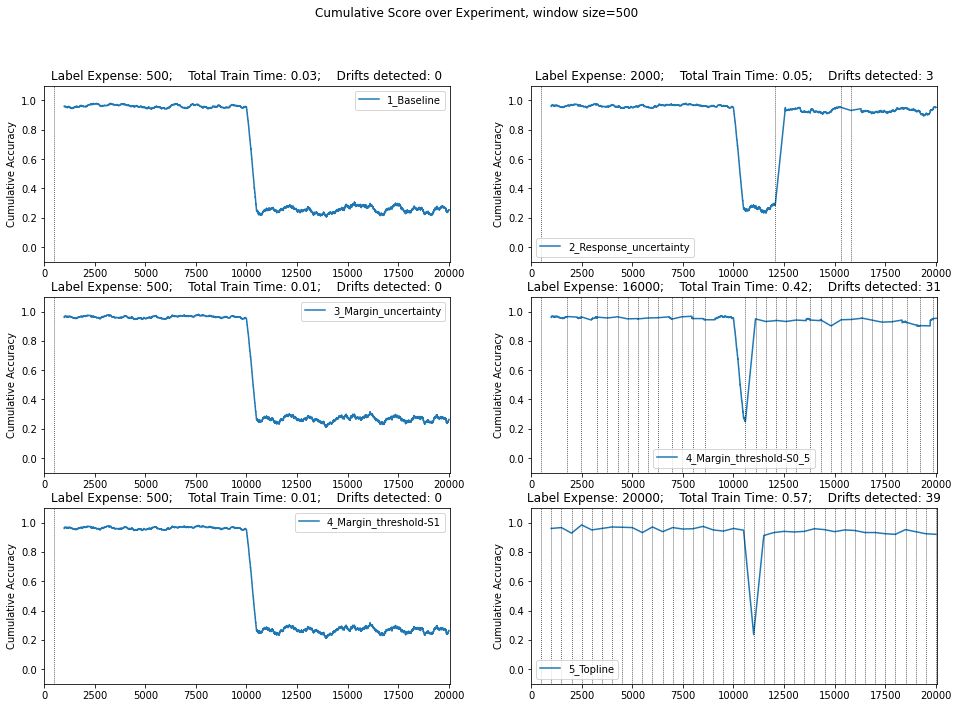

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.03,0.025,0,0,0,0,0.254000,0.000000
2_Response_uncertainty,0.05,0.100,3,5,3,5,0.954000,0.000000
3_Margin_uncertainty,0.01,0.025,0,2,0,2,0.264000,0.000000
4_Margin_threshold-S0_5,0.42,0.800,31,3,30,2,0.957447,0.058824
4_Margin_threshold-S1,0.01,0.025,0,2,0,2,0.264000,0.000000
5_Topline,0.57,1.000,39,3,36,0,0.920000,0.142857


Running experiments with window size = 1500


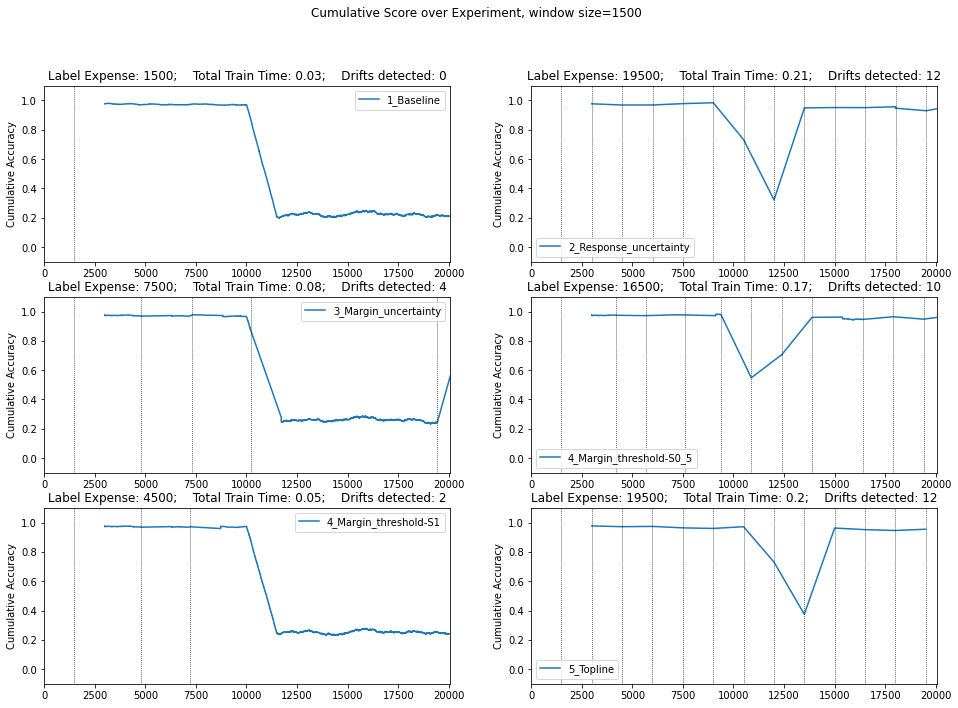

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.03,0.075,0,0,0,0,0.211533,0.000000
2_Response_uncertainty,0.21,0.975,12,1,11,0,0.968354,0.153846
3_Margin_uncertainty,0.08,0.375,4,2,4,2,0.984183,0.000000
4_Margin_threshold-S0_5,0.17,0.825,10,1,9,0,0.975248,0.181818
4_Margin_threshold-S1,0.05,0.225,2,2,2,2,0.241300,0.000000
5_Topline,0.20,0.975,12,1,11,0,0.954667,0.153846


Running experiments with window size = 2500


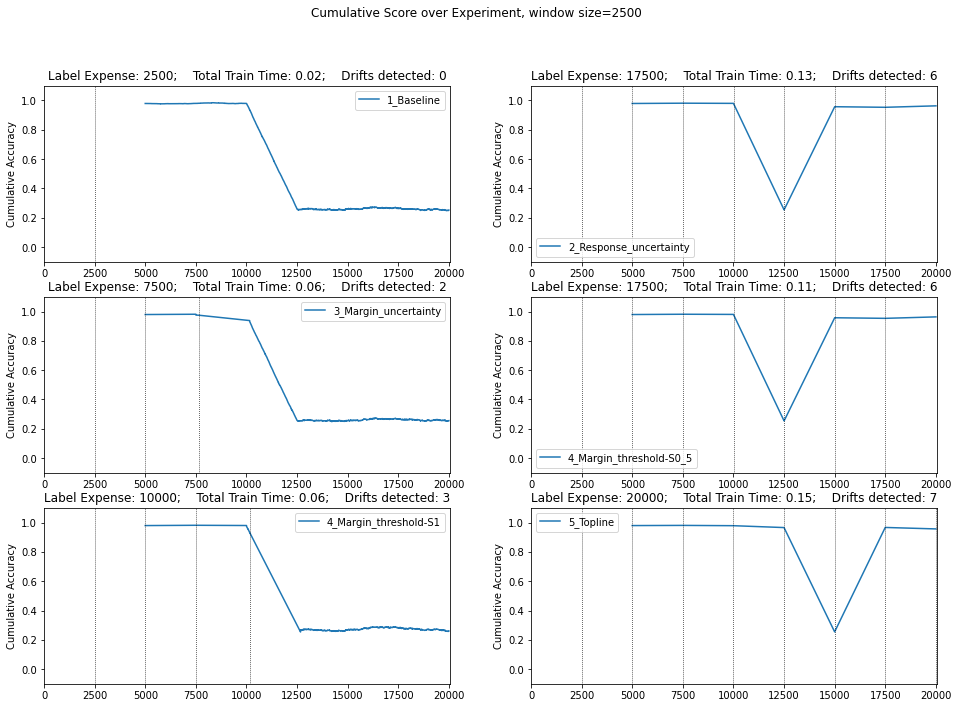

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.02,0.125,0,0,0,0,0.252400,0.000000
2_Response_uncertainty,0.13,0.875,6,1,5,0,0.963527,0.285714
3_Margin_uncertainty,0.06,0.375,2,4,2,4,0.256000,0.000000
4_Margin_threshold-S0_5,0.11,0.875,6,1,5,0,0.963527,0.285714
4_Margin_threshold-S1,0.06,0.500,3,2,3,2,0.260400,0.000000
5_Topline,0.15,1.000,7,1,6,0,0.956800,0.250000


Running experiments with window size = 3500


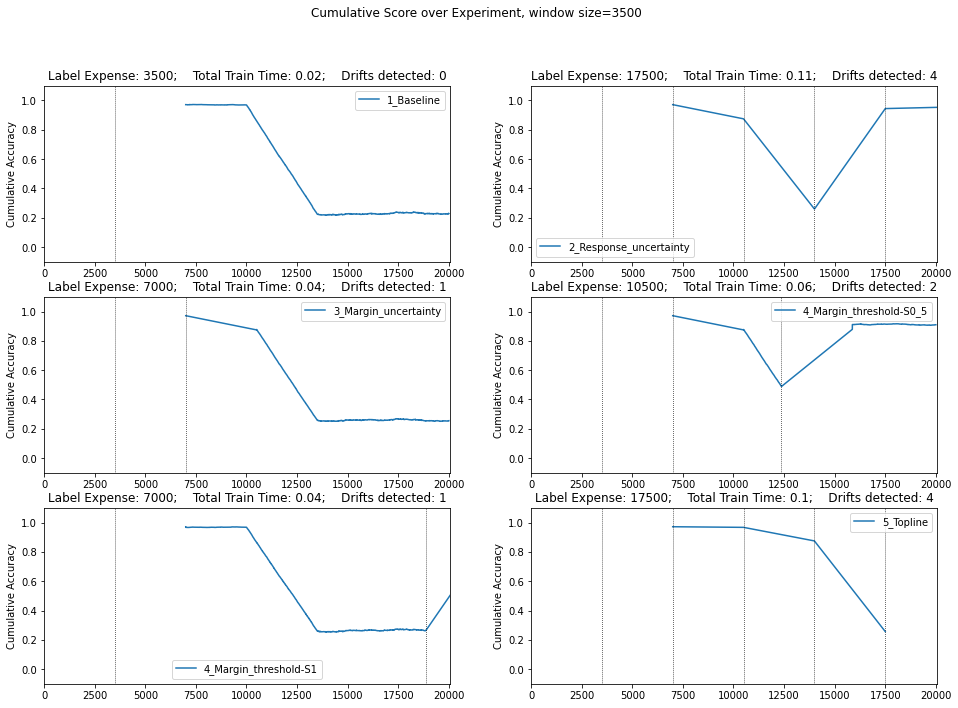

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.02,0.175,0,0,0,0,0.228914,0.0
2_Response_uncertainty,0.11,0.875,4,1,3,0,0.956348,0.4
3_Margin_uncertainty,0.04,0.350,1,3,1,3,0.255129,0.0
4_Margin_threshold-S0_5,0.06,0.525,2,2,2,2,0.910014,0.0
4_Margin_threshold-S1,0.04,0.350,1,2,1,2,0.964789,0.0
5_Topline,0.10,0.875,4,1,3,0,0.256571,0.4


In [5]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500, 3500]:
    # Define dataset
    name_ds = "_7_data_sine_abrupto"
    dataset_7 = Dataset(name_ds, full_df=dataset_sine_abr, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset_7.window_size}")
    exps = define_run_exps(model, param_grid, dataset_7, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset_7.window_size}")
    plt.show()
    #plot_multiple_experiments(exps, change_points)
    display(aggregate_experiment_metrics(exps))


##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


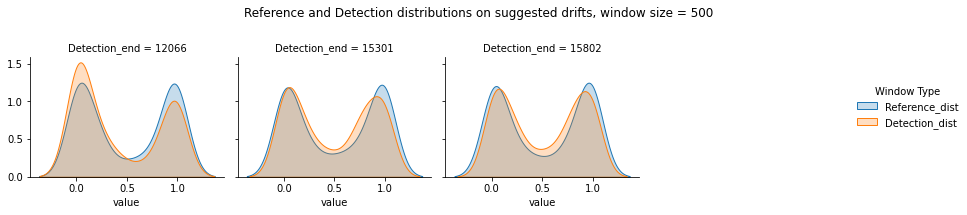

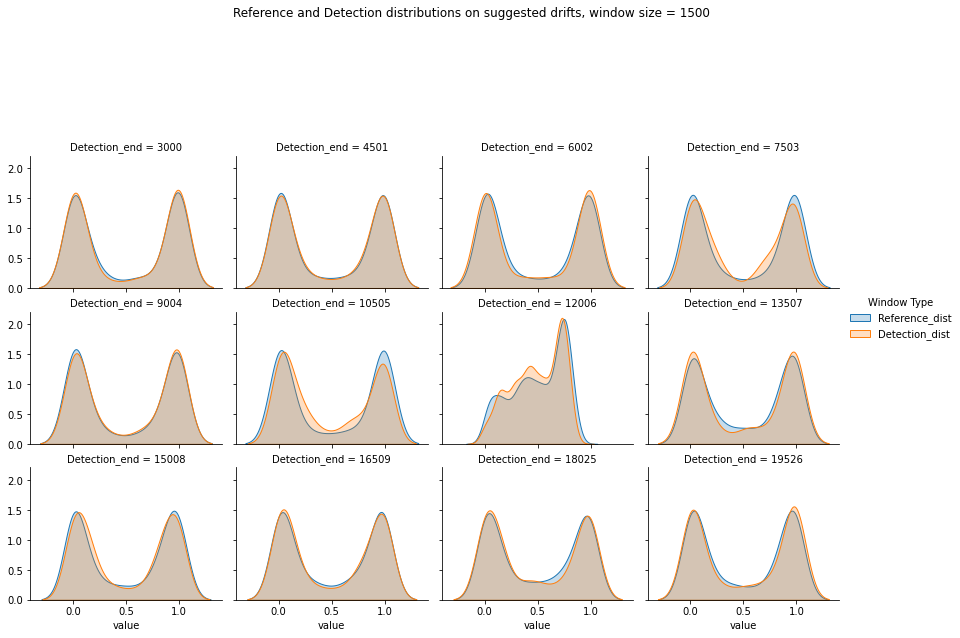

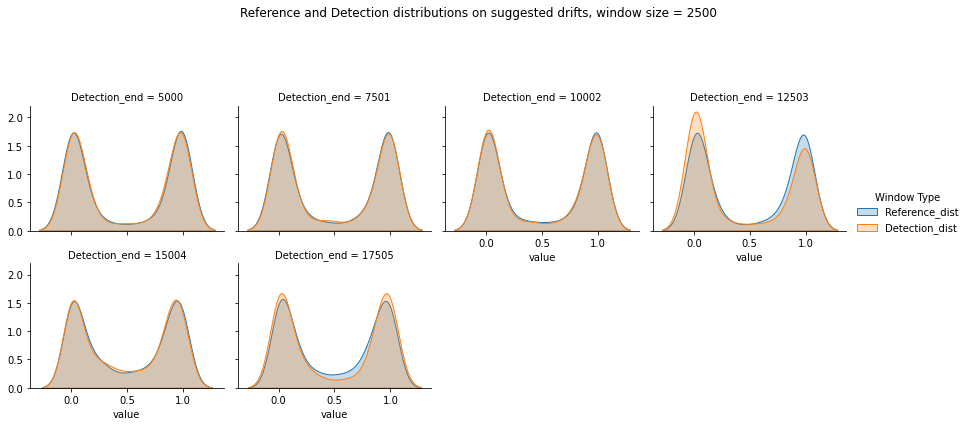

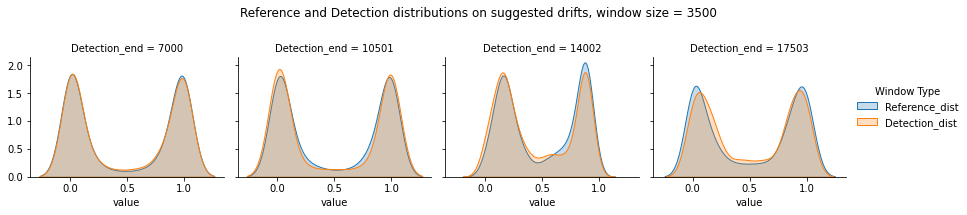

In [6]:
results_KS = pd.read_csv("./results/_7_data_sine_abrupto_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500, 3500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


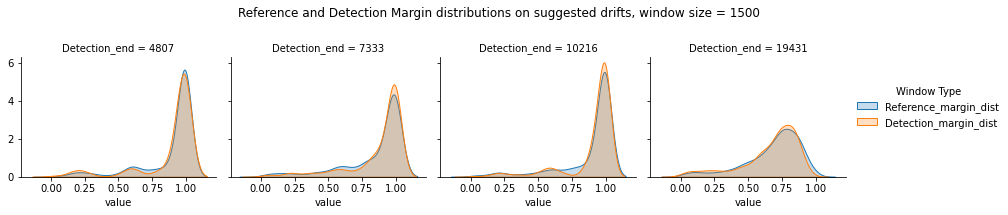

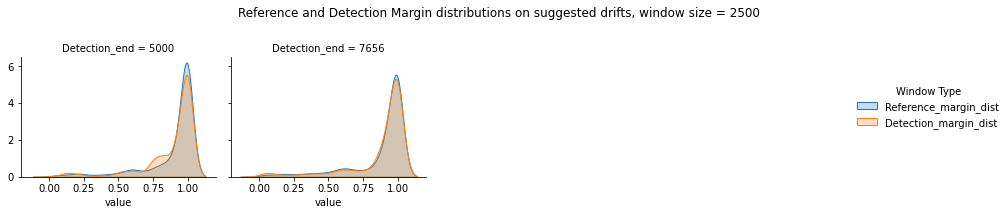

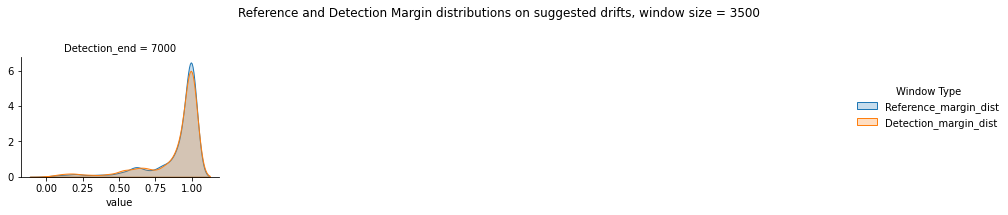

In [7]:
results_XS = pd.read_csv("./results/_7_data_sine_abrupto_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500, 3500])

### Sine - recurrente

In [8]:
# Load data
change_points = [5000,10000,15000]

column_mapping = {
    "target": "target",
    "int_features": [],
    "float_features": ["x", "y"],
}

dataset_sine_rec = pd.read_csv("./datasets/_8_data_sine_recurrente.csv")

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


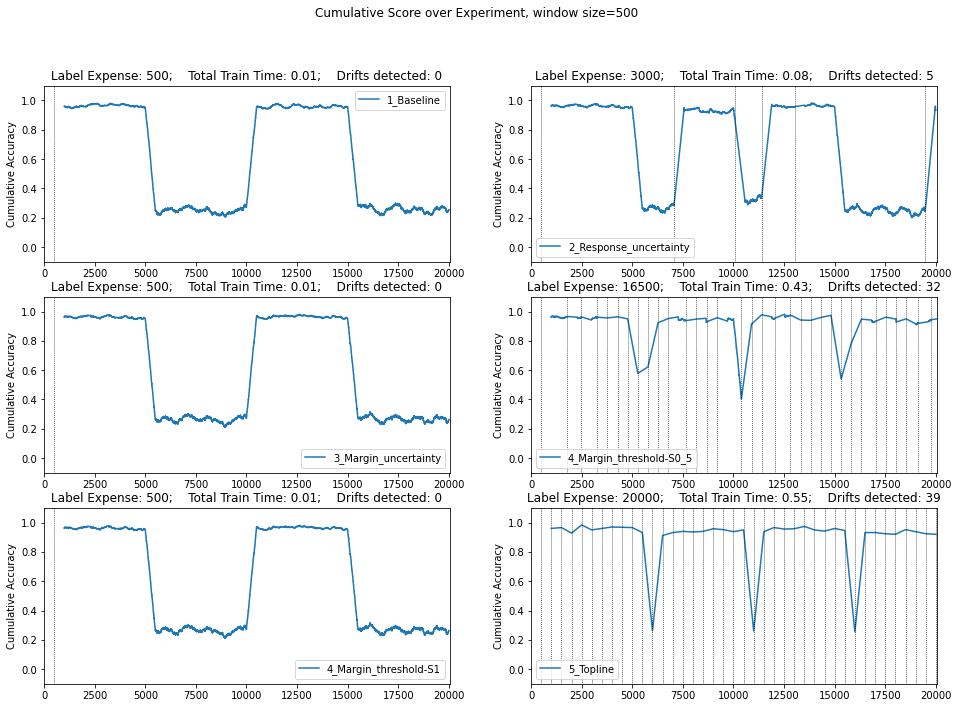

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.01,0.025,0,0,0,0,0.254000,0.000000
2_Response_uncertainty,0.08,0.150,5,16,5,16,0.934000,0.000000
3_Margin_uncertainty,0.01,0.025,0,5,0,5,0.264000,0.000000
4_Margin_threshold-S0_5,0.43,0.825,32,3,30,1,0.955157,0.114286
4_Margin_threshold-S1,0.01,0.025,0,5,0,5,0.264000,0.000000
5_Topline,0.55,1.000,39,4,35,0,0.920000,0.186047


Running experiments with window size = 1500


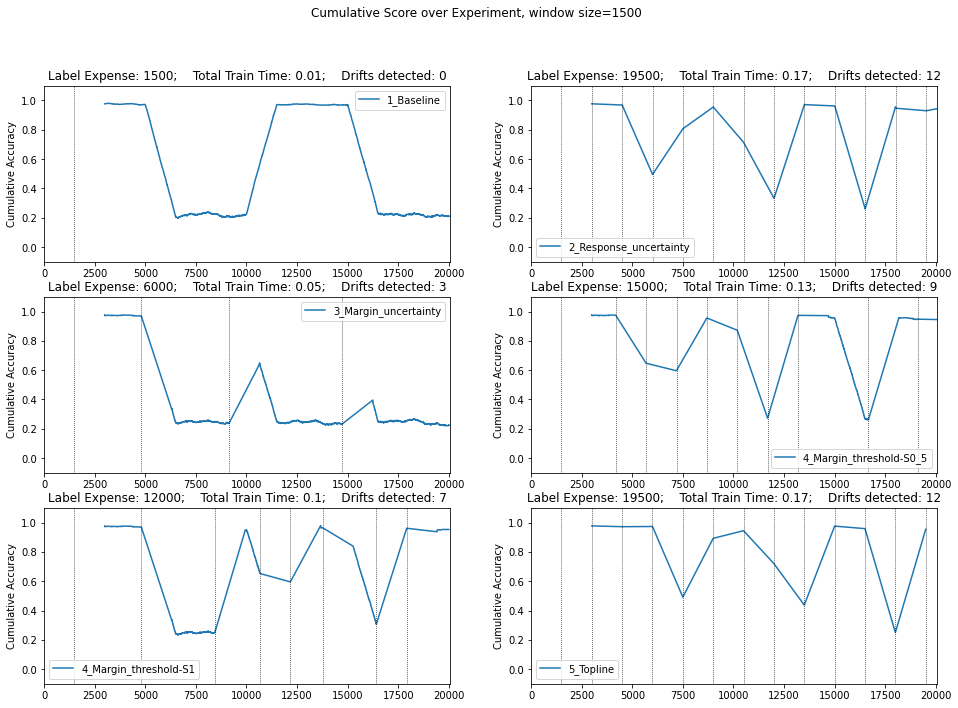

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.01,0.075,0,0,0,0,0.211533,0.000000
2_Response_uncertainty,0.17,0.975,12,3,9,0,0.968354,0.400000
3_Margin_uncertainty,0.05,0.300,3,7,3,7,0.223967,0.000000
4_Margin_threshold-S0_5,0.13,0.750,9,4,7,2,0.943946,0.307692
4_Margin_threshold-S1,0.10,0.600,7,5,6,4,0.952667,0.166667
5_Topline,0.17,0.975,12,3,9,0,0.954667,0.400000


Running experiments with window size = 2500


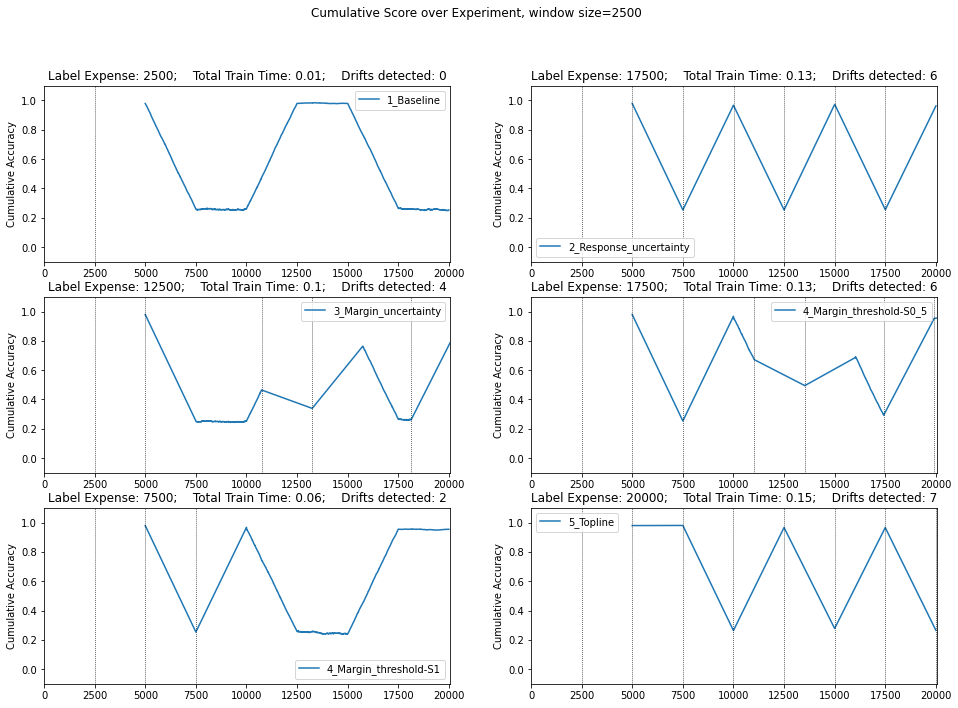

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.01,0.125,0,0,0,0,0.252400,0.000000
2_Response_uncertainty,0.13,0.875,6,1,5,0,0.963527,0.285714
3_Margin_uncertainty,0.10,0.625,4,4,3,3,0.944206,0.250000
4_Margin_threshold-S0_5,0.13,0.875,6,5,3,2,0.986842,0.545455
4_Margin_threshold-S1,0.06,0.375,2,4,1,3,0.954400,0.333333
5_Topline,0.15,1.000,7,1,6,0,0.265600,0.250000


Running experiments with window size = 3500


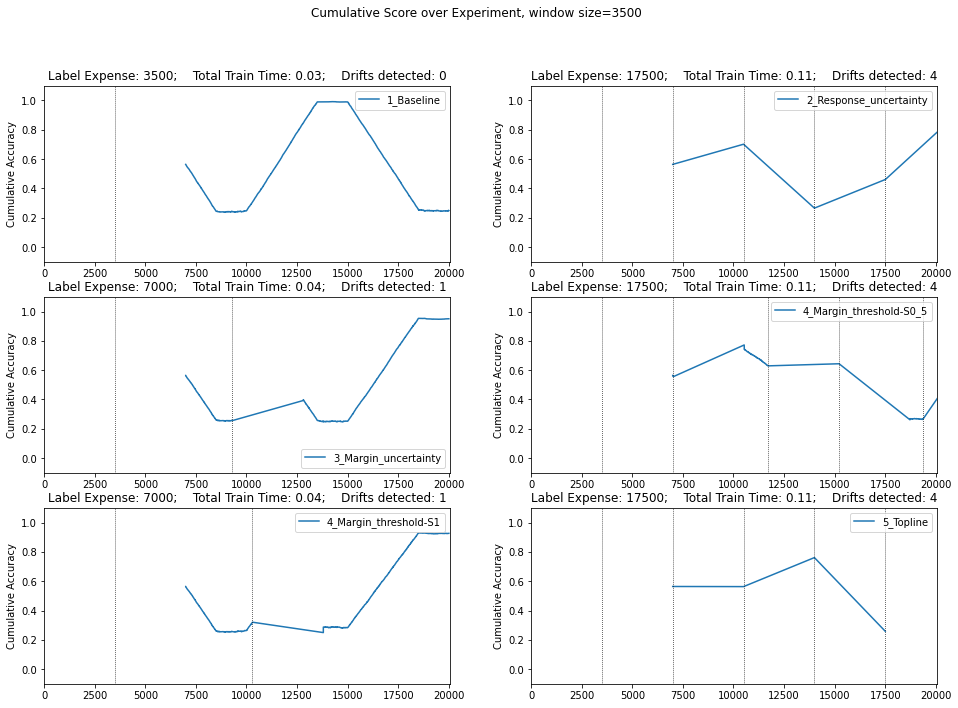

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.03,0.175,0,0,0,0,0.249300,0.000000
2_Response_uncertainty,0.11,0.875,4,2,2,0,0.902683,0.666667
3_Margin_uncertainty,0.04,0.350,1,3,1,3,0.950571,0.000000
4_Margin_threshold-S0_5,0.11,0.875,4,3,4,3,0.964119,0.000000
4_Margin_threshold-S1,0.04,0.350,1,3,1,3,0.926586,0.000000
5_Topline,0.11,0.875,4,2,2,0,0.258557,0.666667


In [9]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500, 3500]:
    # Define dataset
    name_ds = "_8_data_sine_recurrente"
    dataset_8 = Dataset(name_ds, full_df=dataset_sine_rec, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset_8.window_size}")
    exps = define_run_exps(model, param_grid, dataset_8, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset_8.window_size}")
    plt.show()
    #plot_multiple_experiments(exps, change_points)
    display(aggregate_experiment_metrics(exps))

##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


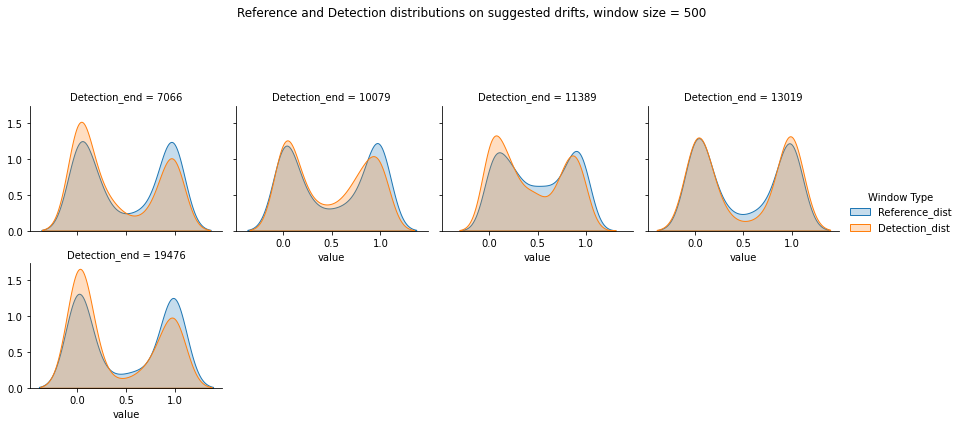

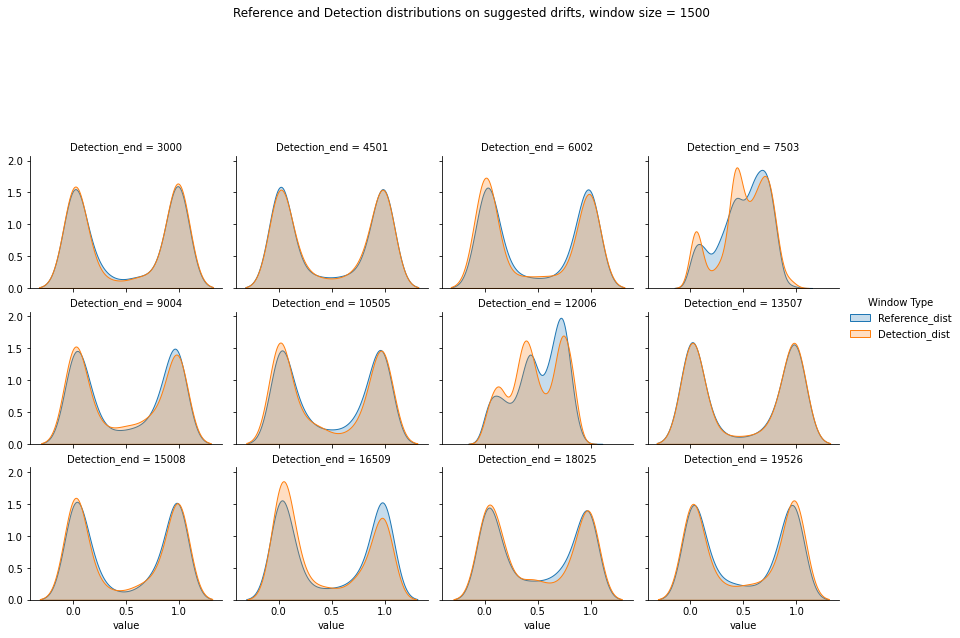

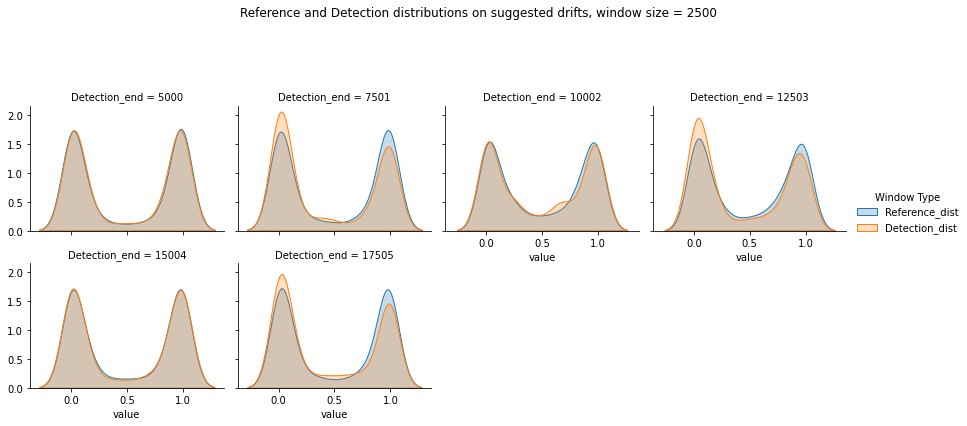

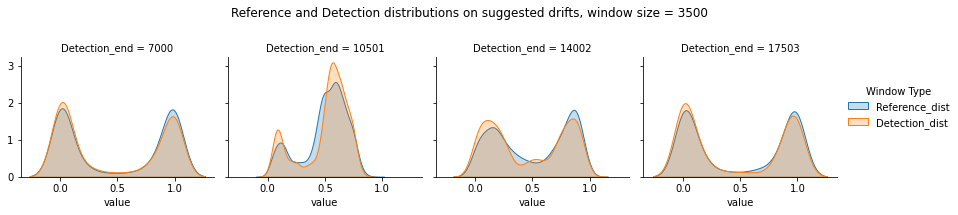

In [10]:
results_KS = pd.read_csv("./results/_8_data_sine_recurrente_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500, 3500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


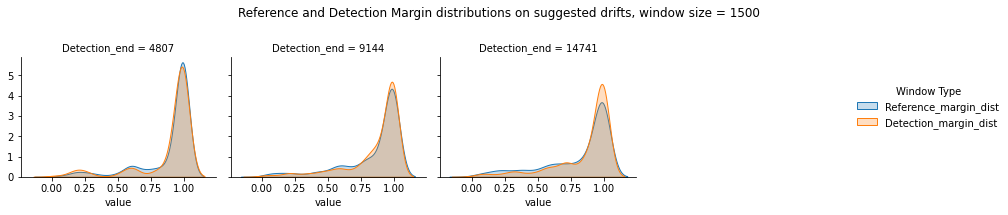

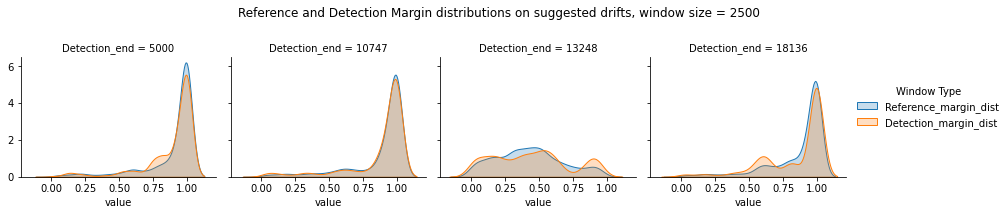

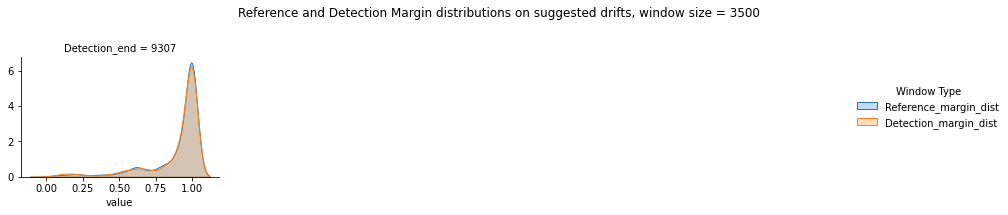

In [11]:
results_XS = pd.read_csv("./results/_8_data_sine_recurrente_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500, 3500])

### Sine - Gradual

In [12]:
# Load data
change_points = [9750]

column_mapping = {
    "target": "target",
    "int_features": [],
    "float_features": ["x", "y"],
}

dataset_sine_grad = pd.read_csv("./datasets/_9_data_sine_gradual.csv")

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


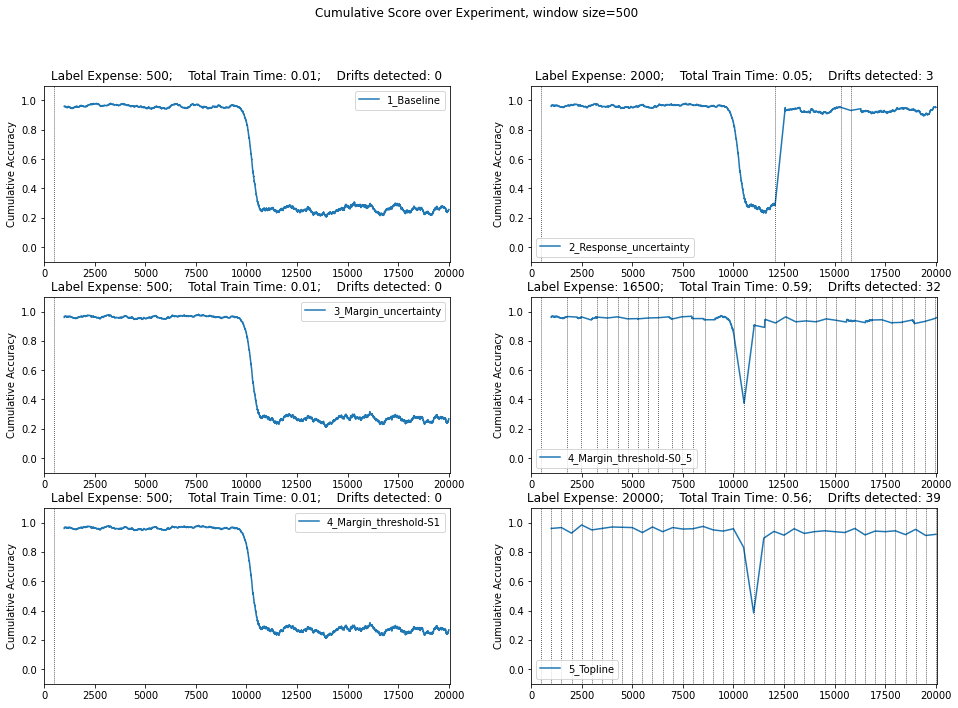

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.01,0.025,0,0,0,0,0.256000,0.00
2_Response_uncertainty,0.05,0.100,3,6,3,6,0.954000,0.00
3_Margin_uncertainty,0.01,0.025,0,3,0,3,0.268000,0.00
4_Margin_threshold-S0_5,0.59,0.825,32,3,32,3,0.983333,0.00
4_Margin_threshold-S1,0.01,0.025,0,3,0,3,0.268000,0.00
5_Topline,0.56,1.000,39,1,38,0,0.920000,0.05


Running experiments with window size = 1500


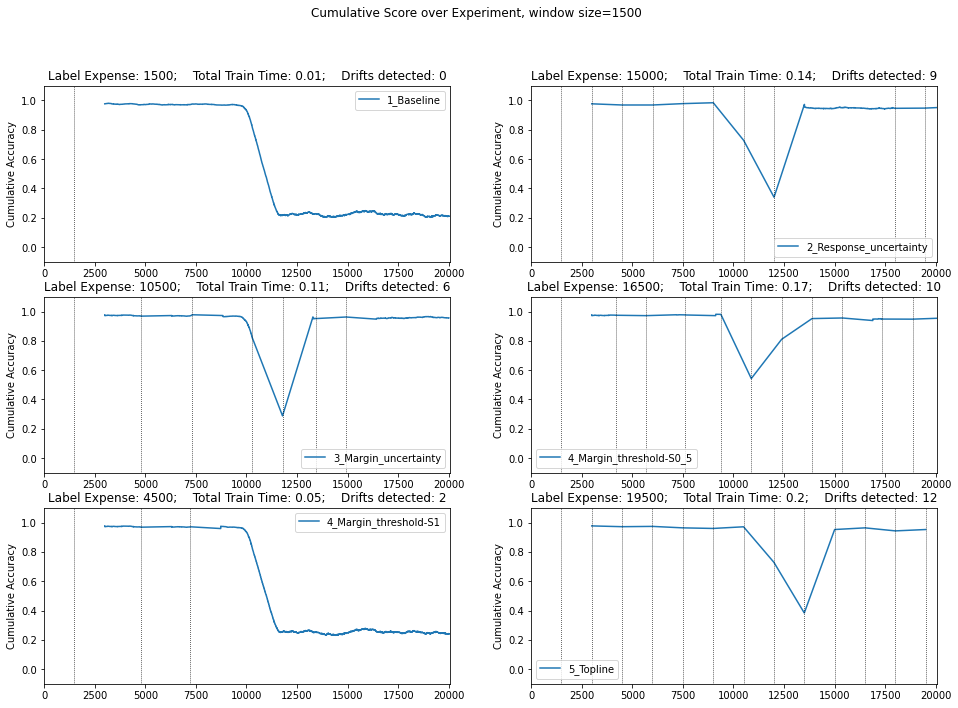

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.01,0.075,0,0,0,0,0.210833,0.000000
2_Response_uncertainty,0.14,0.750,9,1,8,0,0.957328,0.200000
3_Margin_uncertainty,0.11,0.525,6,2,5,1,0.956667,0.250000
4_Margin_threshold-S0_5,0.17,0.825,10,1,9,0,0.955575,0.181818
4_Margin_threshold-S1,0.05,0.225,2,2,2,2,0.239967,0.000000
5_Topline,0.20,0.975,12,1,11,0,0.952667,0.153846


Running experiments with window size = 2500


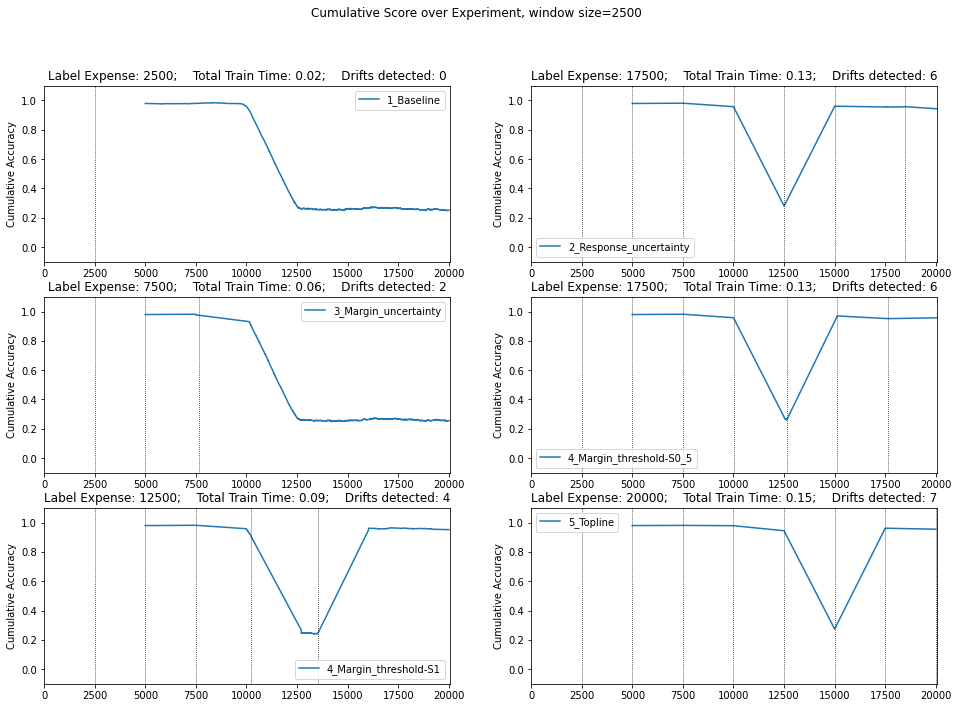

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.02,0.125,0,0,0,0,0.252400,0.00
2_Response_uncertainty,0.13,0.875,6,2,4,0,0.935484,0.50
3_Margin_uncertainty,0.06,0.375,2,2,2,2,0.256400,0.00
4_Margin_threshold-S0_5,0.13,0.875,6,2,5,1,0.957312,0.25
4_Margin_threshold-S1,0.09,0.625,4,2,4,2,0.952000,0.00
5_Topline,0.15,1.000,7,1,6,0,0.954800,0.25


Running experiments with window size = 3500


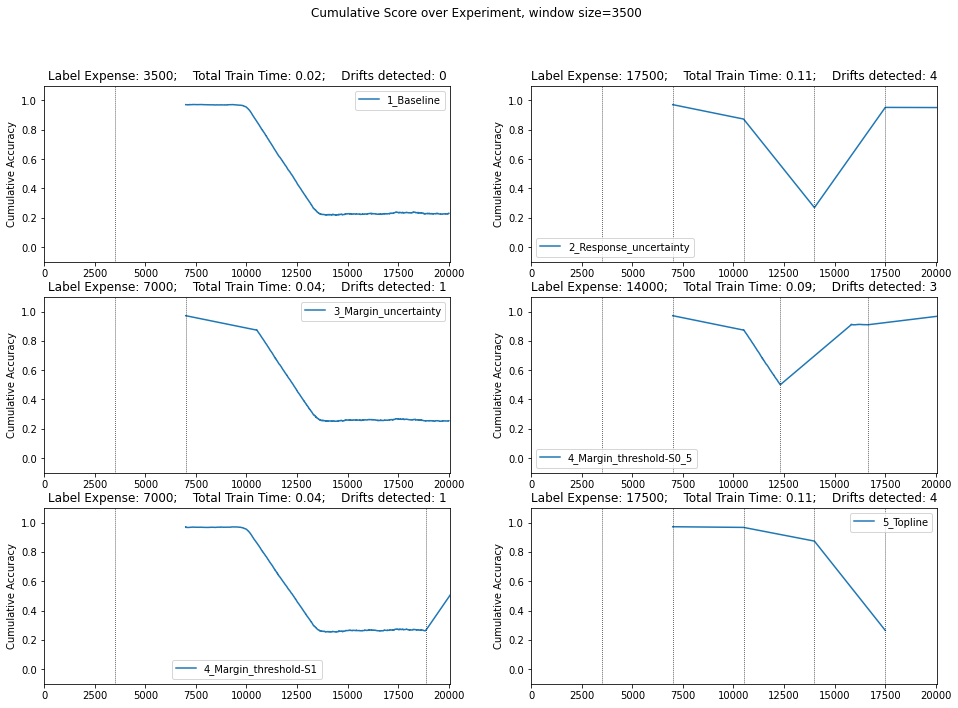

,Total training,% Labels used,Drift signaled,Drift occurred,False positives,False negatives,Cum. accuracy,F1 Score
Experiment,,,,,,,,
1_Baseline,0.02,0.175,0,0,0,0,0.229514,0.0
2_Response_uncertainty,0.11,0.875,4,1,3,0,0.951542,0.4
3_Margin_uncertainty,0.04,0.350,1,3,1,3,0.255143,0.0
4_Margin_threshold-S0_5,0.09,0.700,3,2,3,2,0.968787,0.0
4_Margin_threshold-S1,0.04,0.350,1,2,1,2,0.965004,0.0
5_Topline,0.11,0.875,4,1,3,0,0.264571,0.4


In [13]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500, 3500]:
    # Define dataset
    name_ds = "_9_data_sine_gradual"
    dataset_9 = Dataset(name_ds, full_df=dataset_sine_grad, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset_9.window_size}")
    exps = define_run_exps(model, param_grid, dataset_9, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset_9.window_size}")
    plt.show()
    #plot_multiple_experiments(exps, change_points)
    display(aggregate_experiment_metrics(exps))

##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


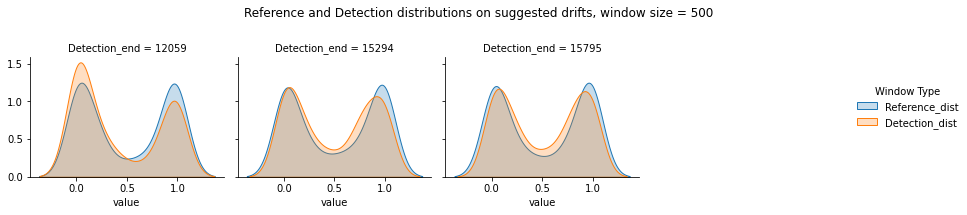

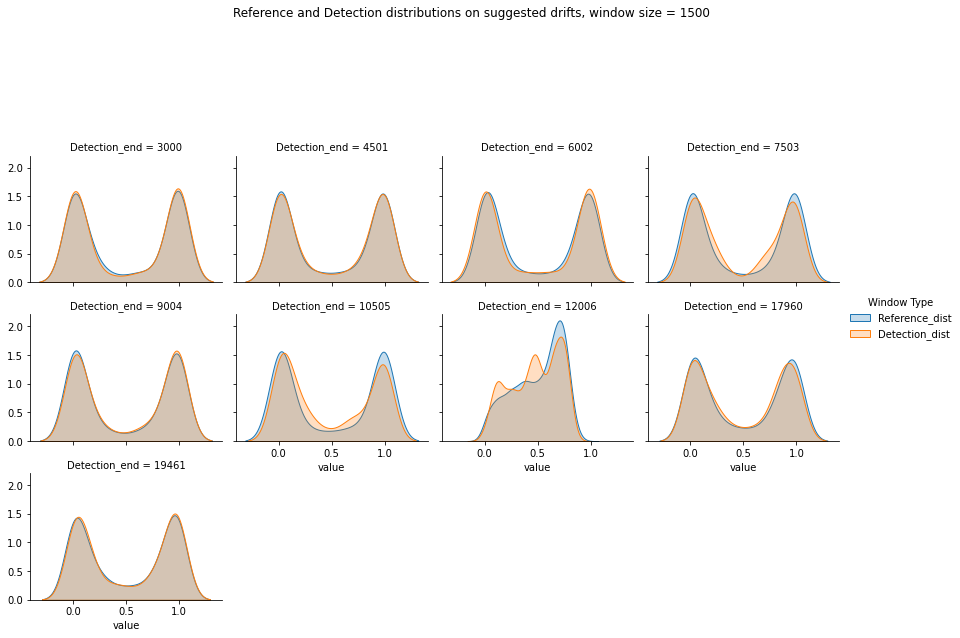

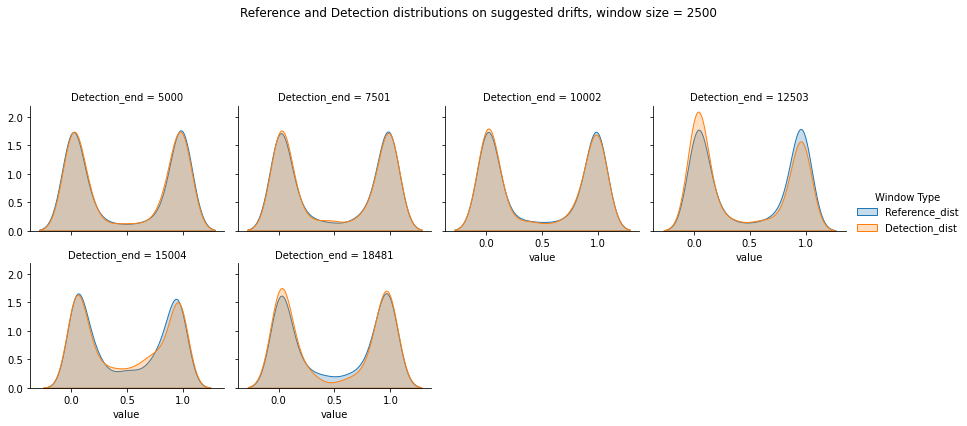

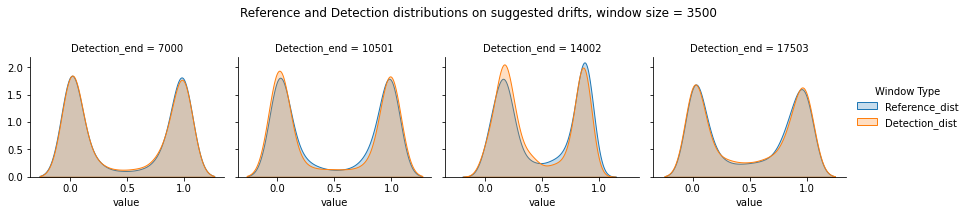

In [14]:
results_KS = pd.read_csv("./results/_9_data_sine_gradual_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500, 3500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


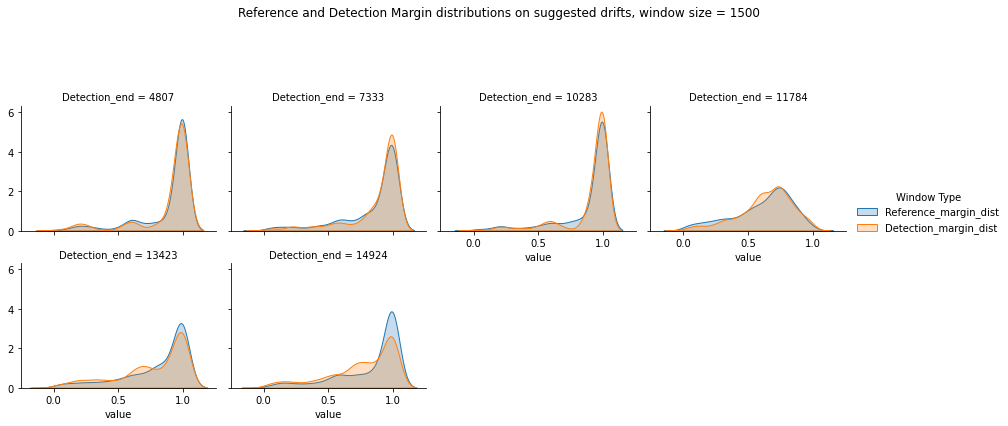

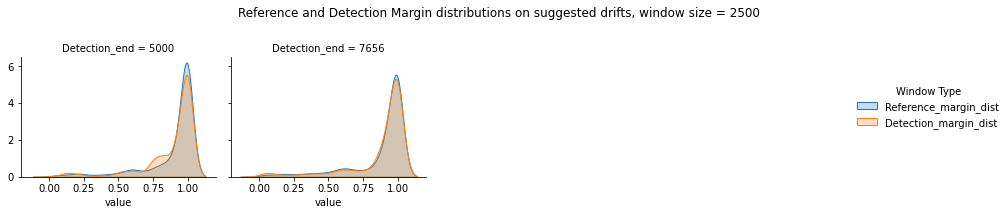

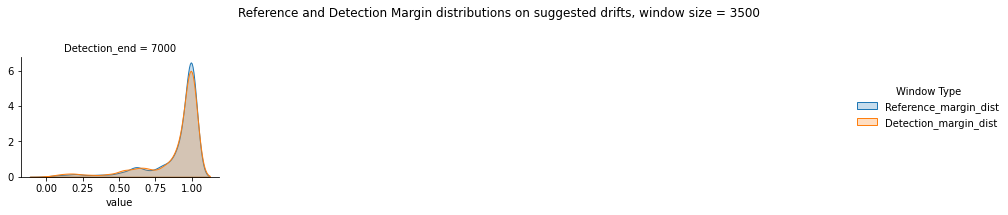

In [15]:
results_XS = pd.read_csv("./results/_9_data_sine_gradual_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500, 3500])